## Maximum Diversification Investment Strategy
Use Index of representative asset classes
Developed-Emerging Equity, Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included
#### Optimization method is used to build portfolio
Market data from 2006 to 2022 are used to drive calculate optimal portfolio

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [3]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/c/workspace/asset_allocation_strategy/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/c/workspace/asset_allocation_strategy
changed directory is :  /mnt/c/workspace/asset_allocation_strategy


In [4]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [5]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation
from benchmark_strategy._50_50_allocation import _50_50_allocation

[__init__] is executed in 4.66 seconds
[__init__] is executed in 4.15 seconds
[__init__] is executed in 4.61 seconds


In [6]:
import quantstats
from scipy.optimize import minimize

## Mean Variance Strategy Backtest for long time.

Use previous month data to build portfolio. For example, use 2022 April market data for 2022 May data.  

Investment universe are below:
|Ticker|Name|Inception|
|-----|----------------------------|---------|
|SPY|SPDR S&P 500 ETF Trust |1993-01-22|
|EFA|iShares MSCI EAFE ETF |2001-08-14|
|EEM|iShares MSCI Emerging Markets ETF |2003-04-07|
|SHY|iShares 1-3 Year Treasury Bond ETF|2002-07-22|yfinance_list| 
|IEF|iShares 7-10 Year Treasury Bond ETF|2002-07-22|yfinance_list| 
|TLT|iShares 20+ Year Treasury Bond ETF|2002-07-22|yfinance_list| 
|LQD|iShares iBoxx Investment Grade Corporate Bond ETF|2002-07-22|

Contraint : each asset classes should be more than 3%, less than 30%

Used scipy minimize modules to find max sharpe ratio portfolio  


In [7]:
start_date='2006-01-01'
end_date='2022-06-01'
cost=0.001

In [11]:
class MinVarianceWeightGenerator(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)

    def compute_target(self, universe_list):


        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        # print(self.bdates[1], self.bdates[-1])
        # print(engine.date)

        date = engine.date

        target_weight = {}
        target_weight = self.compute_factor(date=date,  tickers=universe_list)

        return target_weight


    def compute_factor(self, date, tickers):
        """
        Inputs
            ticker(str) : name of ETF
            ftype(str) : name of factor
        Outputs
            float
        """
        date_1_month_lag = date - relativedelta(month=1)

        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series
        
        return_df = return_df.loc[date_1_month_lag : date]
        return_df =  return_df.pct_change(1)
        return_df = return_df.fillna(1)
        
        self.return_df_dd = return_df

        def get_ret_vol_sharpe(weight):
            weight = np.array(weight)
            ret = np.sum(return_df.mean() * weight) * 252
            vol = np.sqrt(np.dot(weight.T, np.dot(return_df.cov()*252, weight)))
            # set risk free rate as 1.5%
            sharpe = (ret-0.015)/vol
            return {'return':ret, 'volatility':vol, 'sharpe':sharpe}

        def neg_sharpe(weight):
            # to use convex optimization, change sign to minus to solve minimization problem.
            return get_ret_vol_sharpe(weight)['sharpe'] * -1

        def min_vol(weight):
            # to use convex optimization, finding minimum volatility doesn't require sign change
            return get_ret_vol_sharpe(weight)['volatility']

        # constraint : sum of weight should be less than equal to 1
        def check_sum(weight):
            #return 0 if sum of the weights is 1
            return np.sum(weight)-1

        ######################## starts here #######################-
        cons = (
        {'type':'eq',
        'fun':check_sum}
        )

        upper_bound = 0.40
        lower_bound = 0.05
        bounds = []
        initial = []
        for i in range(len(tickers)):
            bounds.append((lower_bound, upper_bound))
            initial.append(1/len(tickers))
        bounds = tuple(bounds)

        optimizer = minimize(min_vol, initial, method='SLSQP', bounds = bounds, constraints = cons)
        
        weight = []
        for i in range(len(tickers)):
            weight.append(optimizer.x[i])
        
        weights = {}
        i = 0
        for ticker in tickers:
            weights[ticker] = weight[i]
            i = i+1
                
        return weights 

In [12]:
custom_universe = ['SPY','EFA','EEM','TLT','IEF','SHY','LQD']
# custom_universe = ['SPY','EFA','IEF','SHY']

engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
mvg = MinVarianceWeightGenerator(engine.cache)
engine.run_backtest(target_generator=mvg, sdate=start_date, edate=end_date, transaction_cost=cost)

[__init__] is executed in 6.40 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:1.849 / time elapsed:27.9 ===
[run_backtest] is executed in 28.27 seconds


In [13]:
myasset = engine.asset_df.sum(axis=1)
myasset

2006-01-03    0.999000
2006-01-04    1.000978
2006-01-05    1.000820
2006-01-06    1.002402
2006-01-09    1.003278
                ...   
2022-05-25    1.857627
2022-05-26    1.861469
2022-05-27    1.867889
2022-05-31    1.857452
2022-06-01    1.849250
Length: 4132, dtype: float64

In [14]:
custom_universe = ['SPY','EFA','EEM','TLT','IEF','SHY','LQD']
# custom_universe = ['SPY','EFA','IEF','SHY']

bm_engine = BacktestEngine(yfinance_list=custom_universe)
equal_weight = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal_weight, sdate=start_date, edate=end_date, transaction_cost=cost)
benchmark = bm_engine.asset_df.sum(axis=1)
benchmark

[__init__] is executed in 8.80 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:2.317 / time elapsed:7.6 === / total_asset:1.460 / time elapsed:3.0 === date:2014-05-30 00:00:00 / total_asset:1.700 / time elapsed:4.0 === / time elapsed:5.9 ===/ time elapsed:6.1 === date:2020-11-30 00:00:00 / total_asset:2.498 / time elapsed:6.8 ===/ time elapsed:7.1 ===
[run_backtest] is executed in 7.77 seconds


2006-01-03    0.999000
2006-01-04    1.002894
2006-01-05    1.002854
2006-01-06    1.008360
2006-01-09    1.010457
                ...   
2022-05-25    2.310684
2022-05-26    2.324135
2022-05-27    2.342991
2022-05-31    2.330066
2022-06-01    2.316651
Length: 4132, dtype: float64

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-06-01  2022-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          85.11%      131.9%
CAGR﹪                     3.82%       5.26%

Sharpe                     0.68        0.6
Prob. Sharpe Ratio         99.67%      99.26%
Smart Sharpe               0.66        0.58
Sortino                    0.95        0.86
Smart Sortino              0.91        0.83
Sortino/√2                 0.67        0.61
Smart Sortino/√2           0.65        0.59
Omega                      1.14        1.14

Max Drawdown               -12.82%     -26.37%
Longest DD Days            440         831
Volatility (ann.)          5.78%       9.21%
R^2                        0.55        0.55
Information Ratio          -0.02       -0.02
Calmar                     0.3         0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-09-03,2022-05-09,2022-06-01,271,-12.819274,-12.616189
2,2008-12-31,2009-03-09,2010-03-16,440,-11.605271,-11.059056
3,2020-03-10,2020-03-18,2020-04-29,50,-11.160877,-10.172606
4,2008-02-04,2008-10-27,2008-12-30,330,-10.013543,-9.512047
5,2010-11-05,2011-03-16,2011-04-26,172,-6.738289,-5.062708


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


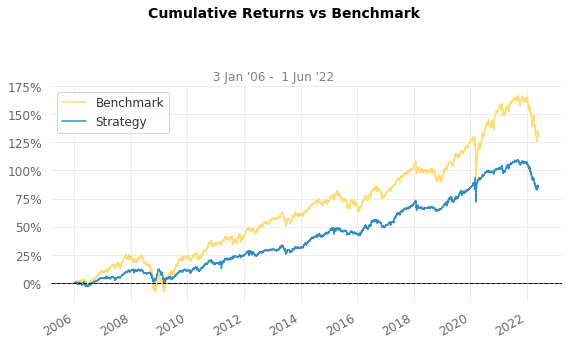

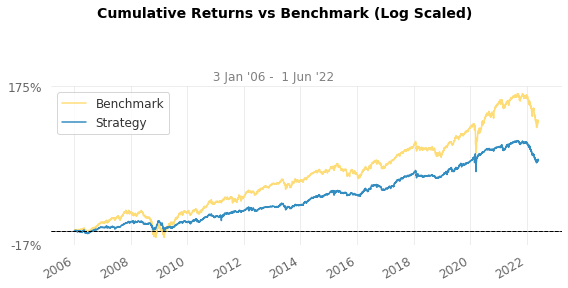

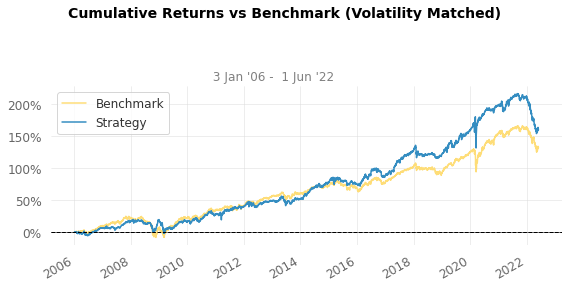

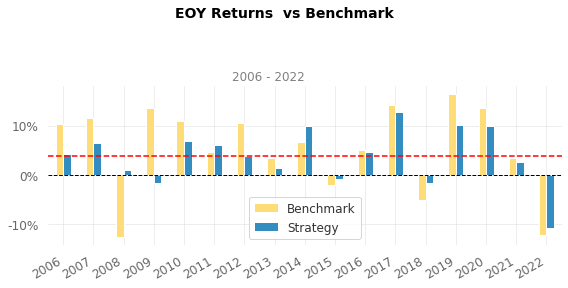

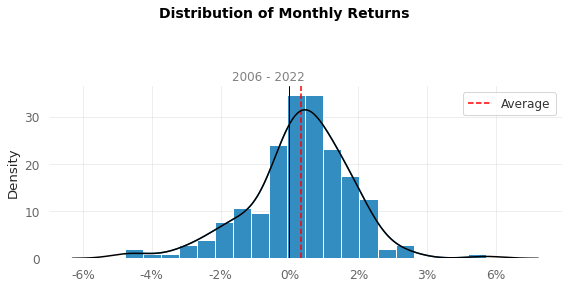

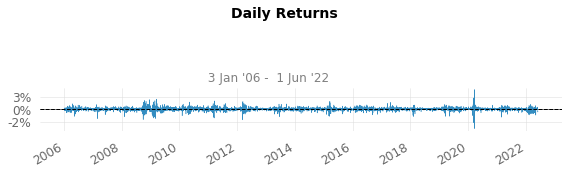

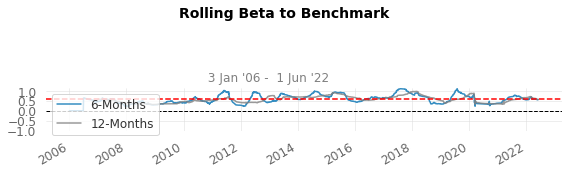

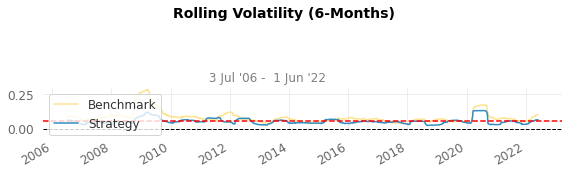

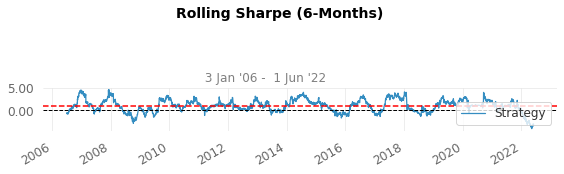

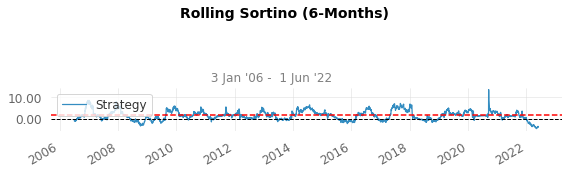

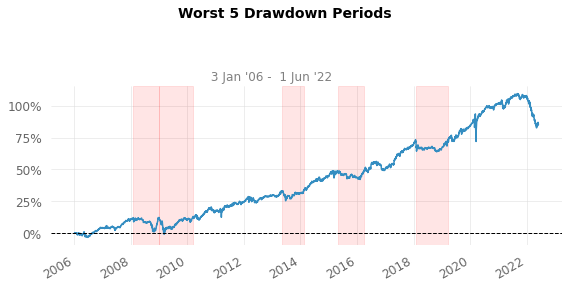

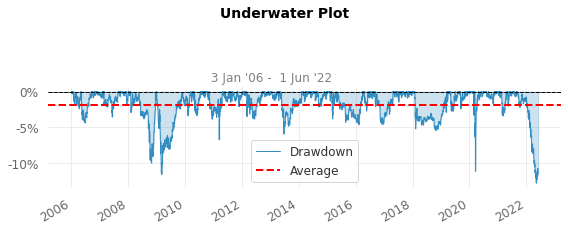

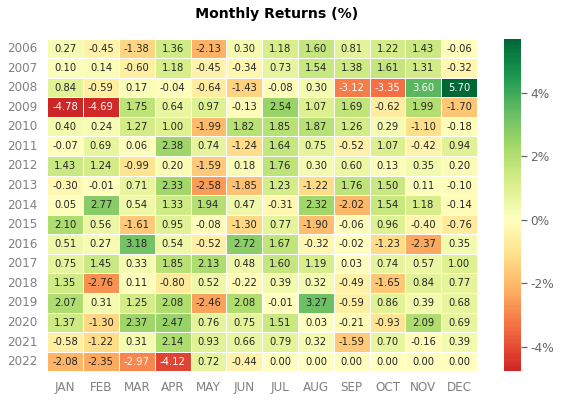

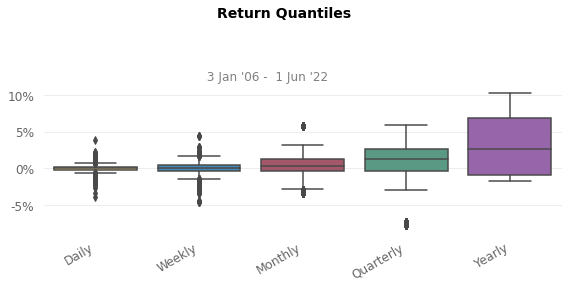

In [15]:
quantstats.reports.full(returns=myasset, benchmark=benchmark)

In [16]:
historical_portfolio = engine.asset_df
weight_historical_portfolio = pd.DataFrame(index=historical_portfolio.index, columns=historical_portfolio.columns)
for date in historical_portfolio.index:
    for ticker in historical_portfolio.columns:
        weight_historical_portfolio.loc[date,ticker] = historical_portfolio.loc[date,ticker]/historical_portfolio.loc[date].sum(axis=0)
weight_historical_portfolio

,cash,SHY,LQD,IEF,TLT,SPY,EFA,EEM
2006-01-03,0.0,0.4,0.20087,0.19913,0.05,0.05,0.05,0.05
2006-01-04,0.0,0.399607,0.200473,0.199092,0.050021,0.050138,0.050316,0.050354
2006-01-05,0.0,0.399323,0.200671,0.199171,0.049969,0.050177,0.050072,0.050618
2006-01-06,0.0,0.398791,0.20004,0.198597,0.049798,0.050515,0.050666,0.051594
2006-01-09,0.0,0.398493,0.199902,0.198518,0.049787,0.0506,0.050646,0.052055
...,...,...,...,...,...,...,...,...
2022-05-25,0.0,0.399028,0.050846,0.344935,0.050431,0.047481,0.059382,0.047897
2022-05-26,0.0,0.3983,0.050754,0.344058,0.050099,0.04833,0.059913,0.048546
2022-05-27,0.0,0.397026,0.050844,0.343368,0.050049,0.049346,0.060428,0.048938
2022-05-31,0.0,0.398635,0.050753,0.341693,0.049265,0.049345,0.060405,0.049903


<AxesSubplot:>

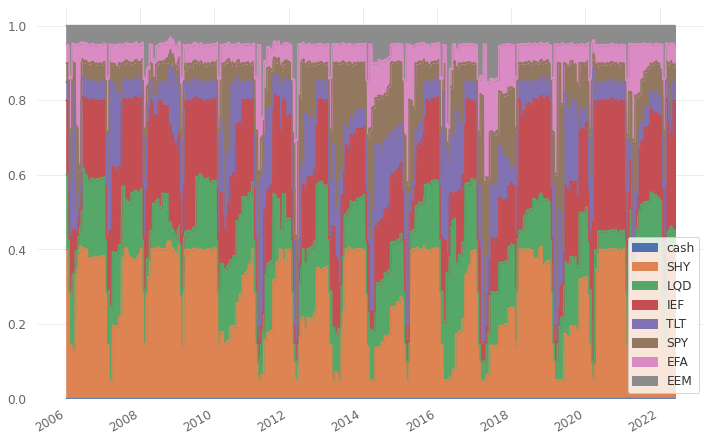

In [17]:
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)
weight_historical_portfolio.plot.area()

## Snap shot of mean-variance portfolio using histrical data
Used market data from Jan 2006 to June 2022 to build portfolio for 2022 July. 

In [18]:
custom_universe = ['SPY','EFA','EEM','TLT','IEF','SHY','LQD']
df = pd.DataFrame()

for ticker in custom_universe:
    _df = engine.cache['index'][ticker]['closeadj'].loc[start_date:end_date]
    df =  pd.concat([df,_df],axis=1)

return_df=df/df.shift(1)
return_df=return_df.fillna(1)

In [19]:
num_ports = 10000
all_weights = np.zeros((num_ports, len(return_df.columns)))
ret, vol, sharpe = np.zeros(num_ports), np.zeros(num_ports), np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(return_df.columns)))
    weights = weights/np.sum(weights)

    # Save weights
    all_weights[x,:] = weights

    # Expected Annual return
    ret[x] = np.sum(((return_df.mean()-1) * weights * 252))
    # Expected Annual volatility
    vol[x] = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    # Sharpe Ratio assuming risk free rate is 1.5%
    sharpe[x] = (ret[x]-0.015)/vol[x]

In [20]:
mv_portfolio = pd.DataFrame(index=['portfolio_#','return','volatility','sharpe'], columns=['max_return', 'max_sharpe', 'min_volatility'])

mv_portfolio.loc['portfolio_#', 'max_return'] = ret.argmax()
mv_portfolio.loc['portfolio_#', 'max_sharpe'] = sharpe.argmax()
mv_portfolio.loc['portfolio_#', 'min_volatility'] = vol.argmax()

mv_portfolio.loc['return', 'max_return'] = round(100*ret.max(),2)
mv_portfolio.loc['return', 'max_sharpe'] = round(100*ret[sharpe.argmax()],2)
mv_portfolio.loc['return', 'min_volatility'] = round(100*ret[vol.argmin()],2)

mv_portfolio.loc['volatility', 'max_return'] = round(100*vol[ret.argmax()],2)
mv_portfolio.loc['volatility', 'max_sharpe'] = round(100*vol[sharpe.argmax()],2)
mv_portfolio.loc['volatility', 'min_volatility'] =  round(100*vol.min(),2)

mv_portfolio.loc['sharpe', 'max_return'] = round(sharpe[ret.argmax()],2)
mv_portfolio.loc['sharpe', 'max_sharpe'] = round(sharpe.max(),2)
mv_portfolio.loc['sharpe', 'min_volatility'] = round(sharpe[ret.argmax()],2)

mv_result = pd.DataFrame(index=return_df.columns, columns=['max_return', 'max_sharpe', 'min_volatility'])

for i in range(len(mv_result.index)):
    mv_result['max_return'].iloc[i] = round(all_weights[ret.argmax(),i],2)
for i in range(len(mv_result.index)):
    mv_result['max_sharpe'].iloc[i] = round(all_weights[sharpe.argmax(),i],2)
for i in range(len(mv_result.index)):
    mv_result['min_volatility'].iloc[i] = round(all_weights[vol.argmin(),i],2)


In [21]:
mv_result

,max_return,max_sharpe,min_volatility
SPY,0.58,0.32,0.0
EFA,0.01,0.0,0.0
EEM,0.22,0.0,0.05
TLT,0.03,0.22,0.01
IEF,0.08,0.36,0.23
SHY,0.04,0.04,0.5
LQD,0.03,0.06,0.21


In [22]:
mv_portfolio

,max_return,max_sharpe,min_volatility
portfolio_#,6403,6661,4008
return,9.08,6.56,3.21
volatility,17.36,6.84,3.51
sharpe,0.44,0.74,0.44


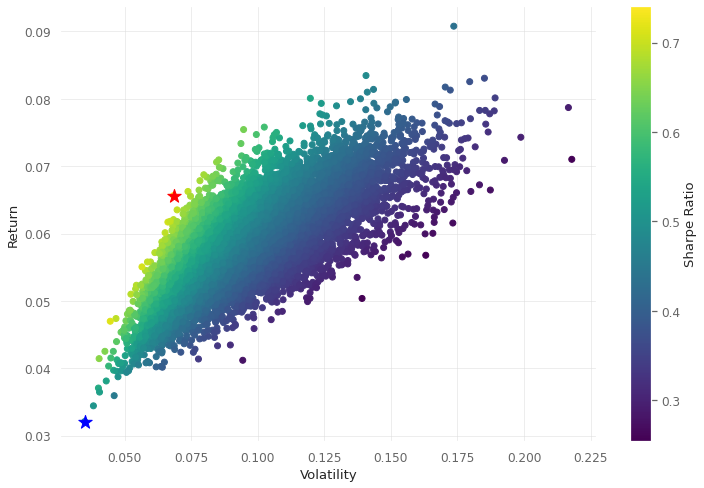

In [23]:
plt.figure(figsize=(12,8))
plt.scatter(vol, ret, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vol[sharpe.argmax()], ret[sharpe.argmax()], c='red', s=200, marker="*") # red star means max sharpe return
plt.scatter(vol[vol.argmin()], ret[vol.argmin()], c='blue', s=200, marker="*") # blue star means min volatility
plt.show()